In [ ]:
# Biblioteki

import eurostat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [68]:
# Konfiguracja

# Wskaźniki
indicators = {
    'nrg_ind_ren': 'OZE_Share',           # Udział OZE w końcowym zużyciu energii [%]
    'nrg_ind_ei':  'Energy_Intensity',    # Energochłonność (kgoe / 1000 EUR)
    'nrg_ind_id':  'Import_Dependency',   # Zależność importowa [%]
}

# Statystyki balansu energetycznego
stats = {
    "nrg_ind_ren": {"nrg_bal": "REN"},           # ogólnie (bez podziału transport, elektryczność itp.)
    "nrg_ind_ei":  {"nrg_bal": "EI_GDP_PPS"}, # w standardzie siły nabywczej
    "nrg_ind_id": {'siec':  'TOTAL'}   # Całkowita (bez podziału węgiel itp.)
}

# Określenie charakteru zmiennych
# S - Stymulanta, D - Destymulanta
variable_types = {
    'OZE_Share': 'S',
    'Energy_Intensity': 'D',
    'Import_Dependency': 'D',
}

GEO = 'PL'

In [69]:
def fetch_and_clean(code, name, geo, stats = stats):
    df = eurostat.get_data_df(code)
    df = df[df['geo\\TIME_PERIOD'] == geo]
    
    key = list(stats[code].keys())[0]
    value = list(stats[code].values())[0]
    df = df[df[key] == value]
            
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df = df[year_cols]
    
    df = df.T
    df.columns = [name]
    df.index.name = 'Rok'
    df.index = df.index.astype(int)
    df = df.sort_index()
    
    return df

In [70]:
# Pobieranie danych
print("Łączenie z API Eurostat...")

dfs = []
for code, name in indicators.items():
    print(f"  - Pobieranie: {name} ({code})")
    d = fetch_and_clean(code, name, GEO)
    dfs.append(d)

data = pd.concat(dfs, axis=1).dropna()
print(f"\nZgromadzono dane dla lat: {data.index.min()} - {data.index.max()}")
print(data.head())

Łączenie z API Eurostat...
  - Pobieranie: OZE_Share (nrg_ind_ren)
  - Pobieranie: Energy_Intensity (nrg_ind_ei)
  - Pobieranie: Import_Dependency (nrg_ind_id)

Zgromadzono dane dla lat: 2004 - 2023
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004      6.882            219.23             14.727
2005      6.867            213.32             17.748
2006      6.859            212.21             20.149
2007      6.903            192.31             25.790
2008      7.686            181.36             30.862


In [71]:
# PCA

df_pca = data.copy()

# Zamiana destymulant na stymulanty
for col, v_type in variable_types.items():
    if col in df_pca.columns and v_type == 'D':
        df_pca[col] = -1 * df_pca[col]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_scaled)
explained_variance = pca.explained_variance_ratio_[0]

data['SMRSE'] = pca_result

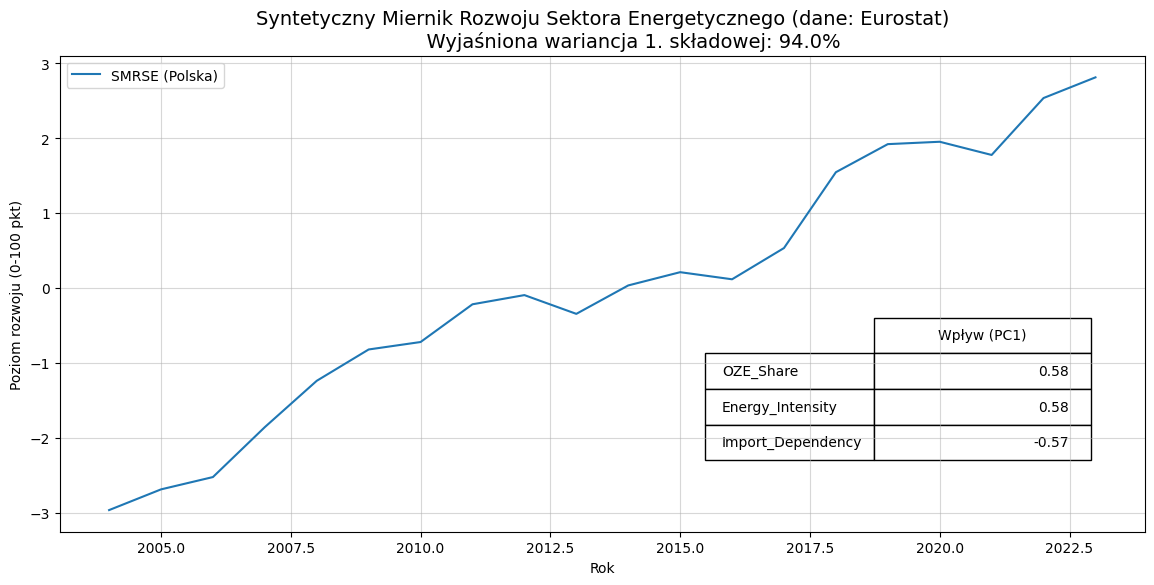


--- Ładunki czynnikowe (korelacja zmiennych z miernikiem) ---
                   Wpływ (PC1)
OZE_Share             0.580758
Energy_Intensity      0.581124
Import_Dependency    -0.570102


In [75]:
plt.figure(figsize=(14, 7))

# Wykres główny
sns.lineplot(x=data.index, y=data['SMRSE'], label='SMRSE (Polska)')

plt.title(f'Syntetyczny Miernik Rozwoju Sektora Energetycznego (dane: Eurostat)\n\
          Wyjaśniona wariancja 1. składowej: {explained_variance:.1%}', fontsize=14)
plt.ylabel('Poziom rozwoju (0-100 pkt)')
plt.xlabel('Rok')
plt.legend()

# Tabela z wagami (ładunki czynnikowe)
loadings = pd.DataFrame(pca.components_.T, columns=['Wpływ (PC1)'], index=df_pca.columns)
plt.table(cellText=np.round(loadings.values, 2),
          rowLabels=loadings.index,
          colLabels=loadings.columns,
          loc='bottom', bbox=[0.75, 0.15, 0.2, 0.3])
plt.subplots_adjust(bottom=0.2)
plt.grid(True, which='major', alpha=0.5)

plt.show()

print("\n--- Ładunki czynnikowe (korelacja zmiennych z miernikiem) ---")
print(loadings)